# COCS2673 Assignment 2 P1A - Cancer detection in images

In [ ]:
#!pip install tensorflow

In [ ]:
#import zipfile
#with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#   zip_ref.extractall('./')

In [ ]:
#!pwd

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

import pandas as pd

tf.__version__

'2.4.1'

# Read Data
Split data into train, validation, and test
Note that images for the same patient may contain a mix of cancerous and non-cancerous data.
Q - Sould we split on patient or just randomly



In [2]:
mainData = pd.read_csv('./data_labels_mainData.csv')
extraData = pd.read_csv('./data_labels_extraData.csv')

In [3]:
mainData = mainData.sample(2000)   # Sampling used for inital model development
#mainData = mainData.append(extraData, ignore_index=True)

In [4]:
mainData.shape[0]

2000

Update Categorical Data types

In [5]:
mainData.drop(['InstanceID'], axis=1,inplace=True)
mainData.drop(['cellType'], axis=1,inplace=True)
mainData.drop(['cellTypeName'], axis=1,inplace=True)


**There are no missing values in the datasets.**

In [6]:
def BinBreakdown(desc, data):
    neg, pos = np.bincount(data)
    total = neg + pos
    print('{} Class Data:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(desc, total, pos, 100 * pos / total))

In [7]:
BinBreakdown('Input Data', mainData.isCancerous)

Input Data Class Data:
    Total: 2000
    Positive: 818 (40.90% of total)



# Train/Validation/Test Split on Patients

### Add classification class

In [8]:
mainData['isCancerous'] = mainData['isCancerous'].astype('str')

### Split Data into Train/Validate/Test
For test and training data split via person.
This assumes that if a person has cancer or not, then would the images for that person have cancer.
Also different cell types per person would be used for validation/testing.

In [9]:
# Get list of patients and observation counts
# Allocate approc 25% of data for Validation and Testing - of that 60%/40% for validation/test split.
TEST_RATIO = 0.10
VAL_RATIO = 0.15


In [10]:
# Split train tests by ratios
# Select random patients until the number of images for 
# each patient sums to the number of records require

np.random.seed(43) # Consistent random list

recCount = mainData.shape[0]
custRec = mainData.patientID.value_counts().to_dict()
    
patientIds = list(custRec.keys())

# Loop through selecting a patient at random summing the number of images they have
# until the count of images crosses is more than required number

testCust = []
testRecs = 0
while (testRecs < (recCount * TEST_RATIO)):
    pId = np.random.choice(patientIds)
    ic = custRec.get(pId)
    patientIds.remove(pId)
    testCust.append(pId)
    testRecs += ic
    
#print(testCust, testRecs)

valCust = []
valRecs = 0
while (valRecs < (recCount * VAL_RATIO)):
    pId = np.random.choice(patientIds)
    ic = custRec.get(pId)
    patientIds.remove(pId)
    valCust.append(pId)
    valRecs += ic

#print(valCust, valRecs)

In [11]:
testData = mainData[mainData.patientID.isin(testCust)]
valData = mainData[mainData.patientID.isin(valCust)]
trainData = mainData[~(mainData.patientID.isin(valCust + testCust))]

In [12]:
totalRecs = mainData.shape[0]
#print(trainData.shape[0] + valData.shape[0] + testData.shape[0])

print("Train data : {}, Val Data: {}, Test Data: {}".format(trainData.shape[0], valData.shape[0], testData.shape[0]))
print("Train data : {:.2f}%, Val Data: {:.2f}%, Test Data: {:.2f}%".format(
    100 * trainData.shape[0] / totalRecs, 100 * valData.shape[0]/totalRecs, 100 * testData.shape[0]/totalRecs))

Train data : 1433, Val Data: 334, Test Data: 233
Train data : 71.65%, Val Data: 16.70%, Test Data: 11.65%


In [13]:
BinBreakdown('Train', trainData.isCancerous)
BinBreakdown('Validation', valData.isCancerous)
BinBreakdown('Test', testData.isCancerous)

Train Class Data:
    Total: 1433
    Positive: 575 (40.13% of total)

Validation Class Data:
    Total: 334
    Positive: 107 (32.04% of total)

Test Class Data:
    Total: 233
    Positive: 136 (58.37% of total)



([0, 1], <a list of 2 Text xticklabel objects>)

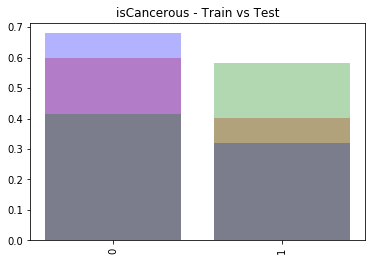

In [14]:
plt.bar(
    trainData.isCancerous.value_counts().index.astype(str), 
    trainData.isCancerous.value_counts().values/np.sum(trainData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='r')

plt.bar(
    valData.isCancerous.value_counts().index.astype(str), 
    valData.isCancerous.value_counts().values/np.sum(valData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='b')

plt.bar(
    testData.isCancerous.value_counts().index.astype(str), 
    testData.isCancerous.value_counts().values/np.sum(testData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='g')

plt.title('isCancerous - Train vs Test')
plt.xticks(rotation='vertical')

**Observations:**
1. Train/Validation/Test data distributions sets have similar distributions

# Images
27x27 RGB 

# Questions
* Results are the same for all models - looks bad but I can work out why
* accuracy jumps around but how to set learning rate?

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training add Data Augmentation to assist with any overfitting (see Sirinukunwattana et al 2016)
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    data_format='channels_last',
    rotation_range=90, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    brightness_range=[0.5,1.5])

val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=valData,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = val_datagen.flow_from_dataframe(
        dataframe=testData,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1433 validated image filenames belonging to 2 classes.
Found 334 validated image filenames belonging to 2 classes.
Found 233 validated image filenames belonging to 2 classes.


### Utility Functions

In [27]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [37]:
def PlotModelFitHistory(mh):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(mh.history['loss'], 'r--')
    plt.plot(mh.history['val_loss'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(mh.history['categorical_accuracy'], 'r--')
    plt.plot(mh.history['val_categorical_accuracy'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()


In [29]:
def PlotConfusionMatrix(test, pred):
    cm = confusion_matrix(test, pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# Model Development

In [30]:
# Use default lambda - note for assignment only. In real this might be in loop to determine best value.
reg_lambda = 0.01

INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
# OUTPUT_CLASSES = 1

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(2, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [31]:
model_reg.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [32]:
model_reg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


In [33]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_reg = model_reg.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

13:14:09
13:17:27
Took =  0:03:17.854049


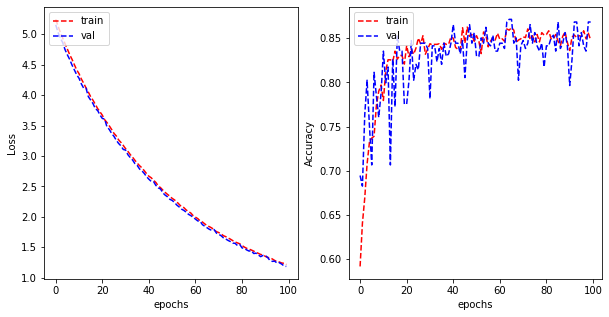

In [38]:
PlotModelFitHistory(history_reg)


In [47]:
pred_y_reg = model_reg.predict(test_generator, batch_size=64, verbose=1)
#pred_y_reg = np.argmax(pred_y_reg, axis=1)

8/8 [==============================] - 0s 15ms/step


In [52]:
pred_y_reg

array([[0.87861836, 0.18729648],
       [0.76036   , 0.34461558],
       [0.83429193, 0.24961612],
       [0.52516603, 0.6020746 ],
       [0.70928377, 0.40544507],
       [0.93376374, 0.10256246],
       [0.5868549 , 0.5424322 ],
       [0.8140649 , 0.27237594],
       [0.92356884, 0.12019554],
       [0.7339568 , 0.37124428],
       [0.8772558 , 0.18495014],
       [0.29491043, 0.79839206],
       [0.61939704, 0.49947286],
       [0.38073483, 0.72821164],
       [0.54863805, 0.5740938 ],
       [0.5582423 , 0.5632057 ],
       [0.7954602 , 0.30112332],
       [0.6455427 , 0.47136754],
       [0.67002535, 0.4467842 ],
       [0.61115116, 0.513562  ],
       [0.83038676, 0.2508665 ],
       [0.83793336, 0.24012697],
       [0.7054143 , 0.40889686],
       [0.63082635, 0.4909954 ],
       [0.8628515 , 0.2026726 ],
       [0.5073106 , 0.61322737],
       [0.36993295, 0.7385653 ],
       [0.74400234, 0.36362413],
       [0.811118  , 0.27858463],
       [0.76888806, 0.33884135],
       [0.

In [54]:
pred_y_reg[1]

array([0.76036   , 0.34461558], dtype=float32)

In [42]:
test_y = testData['isCancerous'].astype('int')

In [45]:
print(classification_report(test_y, pred_y_reg, zero_division=0))

              precision    recall  f1-score   support

           0       0.44      0.67      0.53        97
           1       0.62      0.39      0.48       136

    accuracy                           0.51       233
   macro avg       0.53      0.53      0.51       233
weighted avg       0.55      0.51      0.50       233



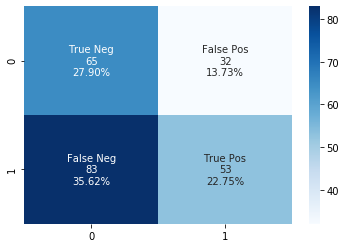

In [46]:
PlotConfusionMatrix(test_y, pred_y_reg)

### Measure 
As this is a screening/detection task, the impact of a false negative is high (ie someone who has cancer is missed)
In this case use Recall for measure.
We can also use F1 to get a more balanced measure of Precision and Recall

Model output is boolean so need to use sigmoid function as probability output of model

### Model Inputs

In [ ]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 1

## 5. VGG 2 with simplified convolutions
* We have 20k images so that should be ok for training
* image size is small so down scaling is not too beneficial
* after 40 epics so could stop early 
* over fitting so reduce the number of convolutions
* Given number of images, data augmentation probably not required


In [ ]:
reg_lambda = 0.01

model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),

    tf.keras.layers.Dense(
        OUTPUT_CLASSES, 
        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        activation='sigmoid' )
])

In [ ]:
adamOpt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_VGG_2.compile(optimizer=adamOpt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['binary_accuracy'])

In [ ]:
model_VGG_2.summary()

In [ ]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_VGG_2 = model_VGG_2.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

In [ ]:
PlotModelFitHistory(history_VGG_2)

In [ ]:
test_y = testData['isCancerous'].astype('int')

pred_y_vgg2 = model_VGG_2.predict(test_generator, batch_size=64, verbose=1)
pred_y_vgg2 = np.argmax(pred_y_vgg2, axis=1)

In [ ]:
print(classification_report(test_y, pred_y_vgg2, zero_division=0))

In [ ]:
PlotConfusionMatrix(test_y, pred_y_vgg2)

### Observations
* The model still took a long time to train
* There looks to be minimal overfitting
* Reducing the number of epochs to 50 showed minimal loss issues but accuracy was jumbled - perhaps training rate too high

*Big Issue* Still not detecting any true cases!